En este cuaderno están las pruebas de intervalos de confianza con diferentes metodos utilizando bootstrap y el método de la distribución normal, además de otros.
Dejo el código con cálculos de intervalo de confianza para futuras pruebas.

```python

#### Modelos de clasificación con selección de características y ajuste de hiperparámetros
 Tipo de Selección utilizada de base para Clasificación : SFS-BSC
 
 Autores:
     - Galván, Hugo César
     - Boveda, Agustina
     - Koss, Pablo
     - Galván, Sebastián
     


In [1]:
import sys
assert sys.version_info >= (3, 5)
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.
%matplotlib inline

In [2]:
# Estandarizador (transforma las variables en z-scores)
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, classification_report, mean_squared_error, confusion_matrix, accuracy_score, precision_score, recall_score # Accuracy metrics 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from scikitplot.metrics import plot_roc


In [3]:
from sklearn.metrics import mean_squared_error


In [4]:
import utils as ut
import pickle
# Indicamos que los tipos de datos float se muestren con 2 decimales
pd.options.display.float_format = '{:.2f}'.format

In [5]:
def balanced_accuracy(cm): # funcion para calcular la "balanced accuracy"
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]

In [6]:
DATA_PATH = "../data/union/End"
def load_data_prep(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "dataset_final.csv")
    return pd.read_csv(csv_path)

In [7]:
df = load_data_prep()

In [8]:
df1 = df[[ 'ccbd_diameter', 'sl2l_mean_length',
 'sl2l_diameter', 'ccbd_mean_length',
 'sl2l_volume', 'tral_volume','label']]
df1.shape

(96, 7)

In [9]:
# Partición en train y test
y = df1.loc[:, df1.columns == 'label']
X = df1.loc[:, df1.columns != 'label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [10]:
std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente

In [11]:
# Ajustamos el estandarizador
std_scale.fit(X_test)
std_scale.fit(X_train)

# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_test_scaled = std_scale.transform(X_test)
X_scaled = std_scale.transform(X_train)

### Modelo de Clasificación: Regresión Logística

In [12]:
logreg = LogisticRegression()
logreg.fit(X_scaled, y_train)

LogisticRegression()

In [13]:
y_train_pred = logreg.predict(X_scaled)
y_pred = logreg.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(logreg.score(X_test_scaled, y_test)))

Accuracy: 0.90


In [14]:
import sklearn.metrics as metrics

In [15]:
y_train_pred.argmax()

2

In [16]:
train_accuracy =  metrics.accuracy_score(y_train_pred,y_train) 
test_accuracy =  metrics.accuracy_score(y_pred, y_test)
print(f'Accuracy en el train set: {train_accuracy:.2f}')
print(f'Accuracy en el test set: {test_accuracy:.2f}')


Accuracy en el train set: 0.74
Accuracy en el test set: 0.90


In [17]:
print(classification_report(y_true=y_test,y_pred=logreg.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.92      0.92      0.92        12

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



In [18]:
y_test_=y_test.values

In [19]:
valor2 = logreg.predict(X_test_scaled.tolist()).tolist()
valor1 = y_test.label.values.tolist()

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valor1, valor2) 
metricas = balanced_accuracy(cm)
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

Matriz de confusion del modelo es:
[[ 7  1]
 [ 1 11]]
Sensibilidad del modelo es de: 0.9167
Especificidad del modelo es de: 0.875
BA del modelo es de: 0.8958


In [21]:
#!pip install -U --upgrade scikit-learn

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 7  1]
 [ 1 11]]


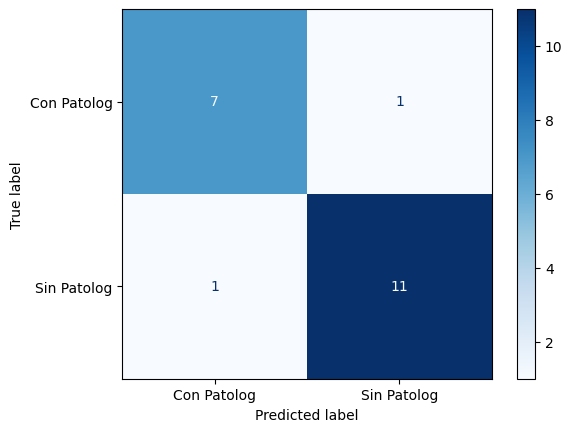

In [23]:
class_names = ['Con Patolog', 'Sin Patolog']
ConfusionMatrixDisplay.from_estimator(logreg, X_test_scaled, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()


In [24]:
import scipy

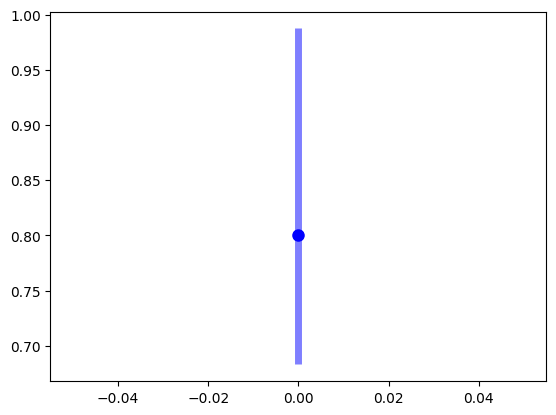

In [25]:
from scipy.stats import binomtest
p = 0.2
data = binomtest((cm[0][0] + cm[1][1]), y_test.shape[0]).proportion_ci()
x = np.arange(scipy.stats.bernoulli.ppf(0.01, p),
              scipy.stats.bernoulli.ppf(0.99, p))
fig, ax = plt.subplots(1, 1)
ax.plot(x, scipy.stats.bernoulli.pmf(x, p), 'bo', ms=8, label='bernoulli pmf')
ax.vlines(x, data[0], data[1], colors='b', lw=5, alpha=0.5)
plt.show()

In [26]:
data = binomtest((cm[0][0] + cm[1][1]), y_test.shape[0]).proportion_ci()
resultados = {}
resultados["Method 1: Regresion Logística"] = {
        "Modelo": 'RegLog',
        "Test accuracy": round(metricas[2],4),
        "Lower 95% CI": data[0],
        "Upper 95% CI": data[1],
    }

In [27]:
# MODEL_PATH = '../data/union/End/model_logreg.pkl'
# with open(MODEL_PATH, 'wb') as f:
#    pickle.dump(logreg, f) 

In [28]:
# !pip install -q -U lightgbm
# !pip install -q -U catboost
# !pip install scikit-plot

### Modelos de Clasificación: 
* XGBClassifier
* LGBMClassifier
* CatBoostClassifier
* Ajustes de hipérparámetros con GridSearchCV
* Transformación de datos numéricos con PolynomialFeatures
* Canalización de datos con Pipeline

In [29]:
num_columns = [ 'ccbd_diameter', 'sl2l_mean_length',
 'sl2l_diameter', 'ccbd_mean_length', 'sl2l_volume', 'tral_volume']

In [30]:
# vamos a usar polynomial features sobre las variables numéricas
poly = PolynomialFeatures()
# Las categorías "nue
# vas" que aparezcan se imputan con el valor de unknown_value
# o_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=99999999)

In [31]:
pipeline = Pipeline([
    ("selector_num", ColumnTransformer(
        [
            ("poly", poly, num_columns)
        ], remainder="passthrough")
    ),
    ("classifier", CatBoostClassifier())
    ]
)

In [32]:
one_to_left = st.beta(10, 1) # Esta distribución nos dará valores entre 0 y 1 mayormente cercanos a 1

In [33]:
# este diccionario de parámetros lo vamos a usar tanto para XGBoost como para LightGBM
params = {  
    "classifier__n_estimators": st.randint(20,150), # n. de árboles.
    "classifier__max_depth": st.randint(3, 12),     # máxima profundiad del árbol
    "classifier__learning_rate": st.uniform(0.05, 0.4), # learning rate (xgb’s “eta”)
    "classifier__colsample_bytree": one_to_left, # ratio de la muestra de las columnas a la hora de construir el árbol
    "classifier__subsample": one_to_left,     # ratio de la muestra de las observaciones
    'classifier__reg_alpha': st.uniform(0.05,10),   # término de regularización L1
    "classifier__min_child_weight": st.uniform(1,20), # Suma mínima del peso de la instancia (hessiano) requerida en los hijos
}

In [34]:
other_params = {"selector_num__poly__degree": [1, 2, 3]}

In [35]:
search_space = [{"classifier": [XGBClassifier(n_jobs=3, eval_metric="logloss", use_label_encoder=False)], 
                 **params,
                 **other_params,
                "classifier__gamma": st.uniform(0, 10), # reducción mínima de la pérdida requerida para hacer un split
                },
                {"classifier": [LGBMClassifier(n_jobs=3, verbose=-1)],
                 **params,
                **other_params},
                {"classifier": [CatBoostClassifier(thread_count=3, verbose=False)],
                 **other_params,
                "classifier__n_estimators": st.randint(20,150), # n. de árboles.
                "classifier__max_depth": st.randint(3, 12),     # máxima profundiad del árbol
                "classifier__learning_rate": st.uniform(0.05, 0.4), # learning rate (xgb’s “eta”)
                "classifier__subsample": one_to_left,     # ratio de la muestra de las observaciones
                },
               {
                   "classifier": [LogisticRegression(max_iter=1000)],
                   "classifier__C": [10**x for x in range(-5, 3)],
               }]

In [36]:
model = RandomizedSearchCV(pipeline, search_space, n_iter=100, verbose=1, cv=3)
model.fit(X_train, y_train)

results = pd.DataFrame(model.cv_results_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [37]:
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier', 'param_classifier__colsample_bytree',
       'param_classifier__learning_rate', 'param_classifier__max_depth',
       'param_classifier__min_child_weight', 'param_classifier__n_estimators',
       'param_classifier__reg_alpha', 'param_classifier__subsample',
       'param_selector_num__poly__degree', 'param_classifier__gamma',
       'param_classifier__C', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [38]:
model.best_score_

0.7235897435897436

In [39]:
model.best_params_

{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8710006530020499, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=3.048615843243047, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.29231771439770493,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=9, max_leaves=None,
               min_child_weight=3.942762403810484, missing=nan,
               monotone_constraints=None, n_estimators=93, n_jobs=3,
               num_parallel_tree=None, predictor=None, random_state=None, ...),
 'classifier__colsample_bytree': 0.8710006530020499,
 'classifier__gamma': 3.048615843243047,
 'classifier__learning_rate': 0.29231771439770493,
 'classif

In [40]:
model.best_estimator_

Pipeline(steps=[('selector_num',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('poly',
                                                  PolynomialFeatures(degree=1),
                                                  ['ccbd_diameter',
                                                   'sl2l_mean_length',
                                                   'sl2l_diameter',
                                                   'ccbd_mean_length',
                                                   'sl2l_volume',
                                                   'tral_volume'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               cols...
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.29231771439770493, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=9,
                               max_leaves=None,
                               min_child_weight=3.942762403810484, missing=nan,
                               monotone_constraints=None, n_estimators=93,
                               n_jobs=3, num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [41]:
X_test_ = pd.DataFrame(X_test, columns=[ 'ccbd_diameter', 'sl2l_mean_length',
 'sl2l_diameter', 'ccbd_mean_length','sl2l_volume', 'tral_volume','label'])

In [42]:
y_predicted = model.predict_proba(X_test_)

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

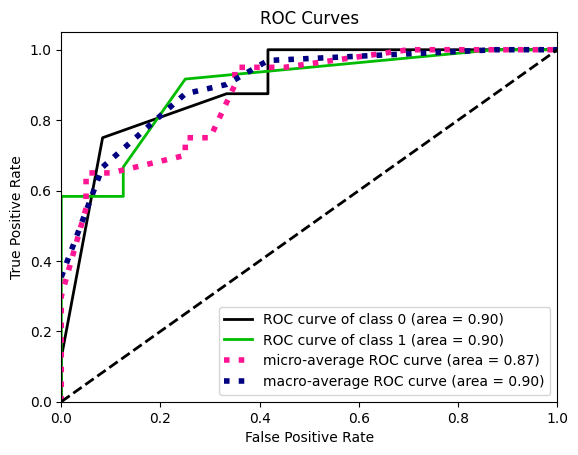

In [43]:
plot_roc(y_test, y_predicted)

In [44]:
roc_auc_score(y_test, y_predicted[:,1])

0.8958333333333333

In [45]:
print(classification_report(y_true=y_test,y_pred=model.predict(X_test_)))

              precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.89      0.67      0.76        12

    accuracy                           0.75        20
   macro avg       0.76      0.77      0.75        20
weighted avg       0.79      0.75      0.75        20



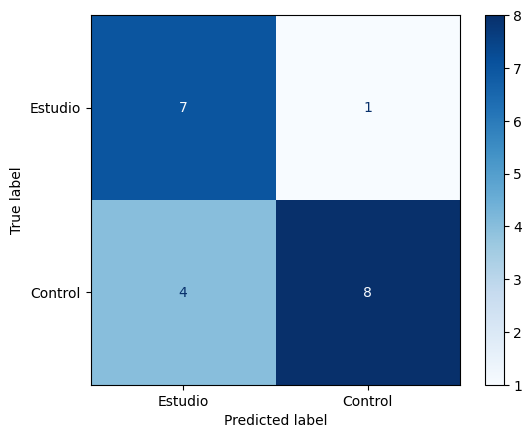

In [46]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(model, X_test_, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [47]:
valor4 = model.predict(X_test).tolist()
valor3 = y_test.label.values.tolist()

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valor3, valor4) 
metricas = balanced_accuracy(cm)
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

Matriz de confusion del modelo es:
[[7 1]
 [4 8]]
Sensibilidad del modelo es de: 0.8889
Especificidad del modelo es de: 0.6364
BA del modelo es de: 0.7626


In [49]:
data = binomtest((cm[0][0] + cm[1][1]), y_test.shape[0]).proportion_ci()

resultados["Method 2: Modelo GV"] = {
        "Modelo": model.best_estimator_,
        "Test accuracy": round(metricas[2],4),
        "Lower 95% CI": data[0],
        "Upper 95% CI": data[1],
    }

In [50]:
# MODEL_PATH = '../data/union/End/model_LGBMClassifier.pkl'
# with open(MODEL_PATH, 'wb') as f:
#     pickle.dump(model.best_estimator_, f) 

In [51]:
model.best_estimator_

Pipeline(steps=[('selector_num',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('poly',
                                                  PolynomialFeatures(degree=1),
                                                  ['ccbd_diameter',
                                                   'sl2l_mean_length',
                                                   'sl2l_diameter',
                                                   'ccbd_mean_length',
                                                   'sl2l_volume',
                                                   'tral_volume'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               cols...
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.29231771439770493, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=9,
                               max_leaves=None,
                               min_child_weight=3.942762403810484, missing=nan,
                               monotone_constraints=None, n_estimators=93,
                               n_jobs=3, num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [52]:
model.predict_proba

<bound method BaseSearchCV.predict_proba of RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('selector_num',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('poly',
                                                                               PolynomialFeatures(),
                                                                               ['ccbd_diameter',
                                                                                'sl2l_mean_length',
                                                                                'sl2l_diameter',
                                                                                'ccbd_mean_length',
                                                                                'sl2l_volume',
                                                                                'tral_volume'])])),
   

In [53]:
# !pip install -q -U ngboost

In [54]:
from ngboost import NGBClassifier
from ngboost.distns import k_categorical, Bernoulli
from ngboost.scores import LogScore
from math import sqrt

In [55]:
ngb_cat = NGBClassifier(Dist=Bernoulli, verbose=False) # tiene 2 estados
model2 = ngb_cat.fit(X_train, y_train) # Y should have only 3 values: {0,1,2}

In [56]:
ngb_cat.predict(X_test)[0:5]

array([0, 1, 0, 0, 1], dtype=int64)

In [57]:
ngb_cat.predict_proba(X_test)[0:5]

array([[6.71106868e-01, 3.28893132e-01],
       [1.20989792e-01, 8.79010208e-01],
       [8.60274409e-01, 1.39725591e-01],
       [9.99145536e-01, 8.54464032e-04],
       [2.29638708e-01, 7.70361292e-01]])

In [58]:
ngb_cat.pred_dist(X_test)[0:5].params

{'p0': array([0.67110687, 0.12098979, 0.86027441, 0.99914554, 0.22963871]),
 'p1': array([3.28893132e-01, 8.79010208e-01, 1.39725591e-01, 8.54464032e-04,
        7.70361292e-01])}

In [59]:
NGBClassifier(Dist=Bernoulli, Score=LogScore, verbose=True).fit(X_train, y_train)

[iter 0] loss=0.6931 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.2034 val_loss=0.0000 scale=4.0000 norm=5.0753
[iter 200] loss=0.1390 val_loss=0.0000 scale=2.0000 norm=2.3745
[iter 300] loss=0.1203 val_loss=0.0000 scale=0.5000 norm=0.5811
[iter 400] loss=0.1111 val_loss=0.0000 scale=2.0000 norm=2.3005


NGBClassifier(random_state=RandomState(MT19937) at 0x1FB229FA440)

In [60]:
preds = ngb_cat.predict(X_test)
score = roc_auc_score(y_test, preds)
print("ROC AUC Score: %f" % score)

ROC AUC Score: 0.791667


In [61]:
valor6 = ngb_cat.predict(X_test).tolist()
valor5 = y_test.label.values.tolist()

In [62]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valor5, valor6) 
metricas = balanced_accuracy(cm)
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

Matriz de confusion del modelo es:
[[8 0]
 [5 7]]
Sensibilidad del modelo es de: 1.0
Especificidad del modelo es de: 0.6154
BA del modelo es de: 0.8077


In [63]:
print(classification_report(y_true=y_test,y_pred=ngb_cat.predict(X_test)))

              precision    recall  f1-score   support

           0       0.62      1.00      0.76         8
           1       1.00      0.58      0.74        12

    accuracy                           0.75        20
   macro avg       0.81      0.79      0.75        20
weighted avg       0.85      0.75      0.75        20



In [64]:
data = binomtest((cm[0][0] + cm[1][1]), y_test.shape[0]).proportion_ci()

resultados["Method 3: Modelo NGB"] = {
        "Modelo": 'NGB',
        "Test accuracy": round(metricas[2],4),
        "Lower 95% CI": data[0],
        "Upper 95% CI": data[1],
    }

In [65]:
# Check the results
'''
print('Desviación Estándar de los valores residuales')
print('RMSE: NGBoost', round(sqrt(mean_squared_error(y_test, valor6)),4))
print('RMSE: Model', round(sqrt(mean_squared_error(y_test,valor4)),4))
print('RMSE: LogRG', round(sqrt(mean_squared_error(y_test,valor2)),4))
'''

"\nprint('Desviación Estándar de los valores residuales')\nprint('RMSE: NGBoost', round(sqrt(mean_squared_error(y_test, valor6)),4))\nprint('RMSE: Model', round(sqrt(mean_squared_error(y_test,valor4)),4))\nprint('RMSE: LogRG', round(sqrt(mean_squared_error(y_test,valor2)),4))\n"

In [66]:
y_test.count()

label    20
dtype: int64

In [67]:
from statsmodels.stats.proportion import proportion_confint

In [68]:
y_test.label.loc[y_test.label == 0].count(), y_predicted[:,1].shape[0]

(8, 20)

In [69]:
lower, upper = proportion_confint(17, 20, 0.05)

print('lower=%.3f, upper=%.3f' % (lower, upper))

lower=0.694, upper=1.000


https://medium.com/@ranjitmaity95/confidence-intervals-in-machinelearning-b727d9dbdfcd

https://sebastianraschka.com/blog/2022/confidence-intervals-for-ml.html

In [70]:
import scipy.stats

confidence = 0.95  # Change to your desired confidence level
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
print(z_value)

import numpy as np

confidence = 0.95  # Change to your desired confidence level
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)

acc_test = model.score(X_test, y_test)
ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

ci_lower = acc_test - ci_length
ci_upper = acc_test + ci_length

print(ci_lower, ci_upper)


1.959963984540054
0.5602273032177509 0.9397726967822491


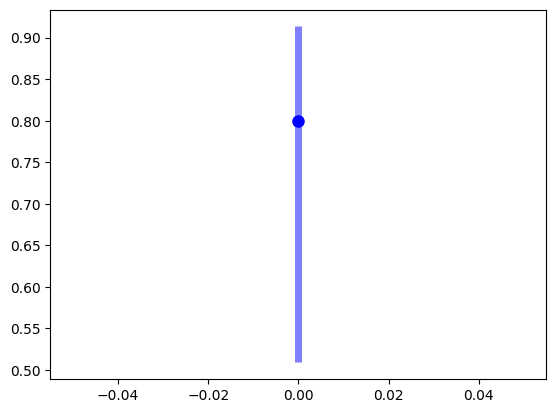

In [71]:
from scipy.stats import binomtest
data = binomtest((cm[0][0] + cm[1][1]), y_test.shape[0]).proportion_ci()
x = np.arange(scipy.stats.bernoulli.ppf(0.01, p),
              scipy.stats.bernoulli.ppf(0.99, p))
fig, ax = plt.subplots(1, 1)
ax.plot(x, scipy.stats.bernoulli.pmf(x, p), 'bo', ms=8, label='bernoulli pmf')
ax.vlines(x, data[0], data[1], colors='b', lw=5, alpha=0.5)
plt.show()

In [72]:
'''
model.score(X_test, y_test)
np.sqrt((acc_test * (1 - acc_test)))
ngb_cat.Dist
'''

'\nmodel.score(X_test, y_test)\nnp.sqrt((acc_test * (1 - acc_test)))\nngb_cat.Dist\n'

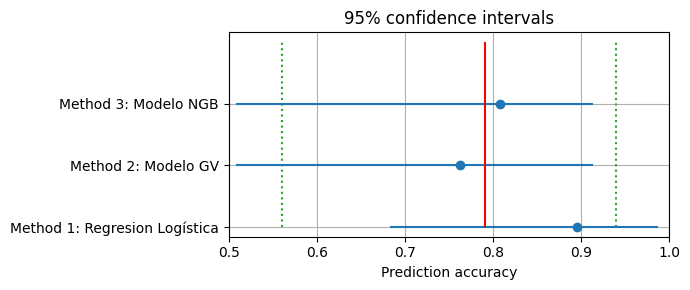

In [73]:
labels = list(resultados.keys())

means = np.array([resultados[k]["Test accuracy"] for k in labels])
lower_error = np.array([resultados[k]["Lower 95% CI"] for k in labels])
upper_error = np.array([resultados[k]["Upper 95% CI"] for k in labels])

asymmetric_error = [means - lower_error, upper_error - means]

fig, ax = plt.subplots(figsize=(7, 3))

ax.vlines(ci_lower, [0], 3, lw=1.5, linestyle="dotted", label="95% CI", color="C2")
ax.vlines(ci_upper, [0], 3, lw=1.5, linestyle="dotted", color="C2")

ax.errorbar(means, np.arange(len(means)), xerr=asymmetric_error, fmt="o")
ax.set_xlim([0.5, 1.0])
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(labels)
ax.set_xlabel("Prediction accuracy")
ax.set_title("95% confidence intervals")

ax.vlines(score, [0], 3, lw=1.5, color="red", linestyle="-", label="True value")


plt.grid()
plt.tight_layout()
plt.show()

In [74]:
resultados["Method 1: Regresion Logística"], resultados["Method 2: Modelo GV"], resultados["Method 3: Modelo NGB"], 

({'Modelo': 'RegLog',
  'Test accuracy': 0.8958,
  'Lower 95% CI': 0.6830172859809209,
  'Upper 95% CI': 0.9876514728297041},
 {'Modelo': Pipeline(steps=[('selector_num',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('poly',
                                                    PolynomialFeatures(degree=1),
                                                    ['ccbd_diameter',
                                                     'sl2l_mean_length',
                                                     'sl2l_diameter',
                                                     'ccbd_mean_length',
                                                     'sl2l_volume',
                                                     'tral_volume'])])),
                  ('classifier',
                   XGBClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bynode=None,
     

In [75]:
dframe = pd.DataFrame([key for key in resultados.keys()], columns=['Name'])

In [76]:
dframe

,Name
0,Method 1: Regresion Logística
1,Method 2: Modelo GV
2,Method 3: Modelo NGB


In [77]:
[resultados[k]["Test accuracy"] for k in labels]

[0.8958, 0.7626, 0.8077]

In [78]:
result = binomtest(3, n=20, p=0.1, alternative='greater')

In [79]:
result.pvalue

0.32307319481053454

### Análisis de regresión logística

In [80]:
# Para regresión lineal hay distintas opciones:
from sklearn.linear_model import LogisticRegressionCV # sci-kit learn
import statsmodels.formula.api as smf
import statsmodels.api as sm # stats models
from sklearn.tree import DecisionTreeClassifier


In [81]:
from sklearn.metrics import f1_score


#### Ajustamos el estandarizador
std_scale.fit(X_test)
std_scale.fit(X_train)

#### Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_test_scaled = std_scale.transform(X_test)
X_scaled = std_scale.transform(X_train)

In [82]:
lr = LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=60, warm_start=True)

In [83]:
lr.fit(X_scaled, y_train)

LogisticRegression(C=0.8, class_weight='balanced', max_iter=60,
                   solver='newton-cg', tol=1e-05, warm_start=True)

In [84]:
# Predicting on the test data
pred_test = lr.predict(X_test_scaled)


#Ploting the confusion matrix
confusion_matrix(y_test, pred_test)

array([[ 7,  1],
       [ 1, 11]], dtype=int64)

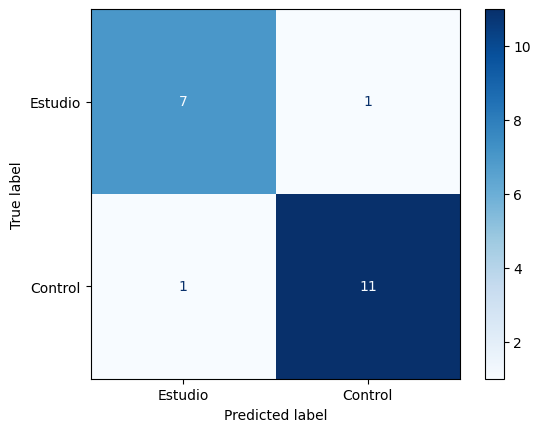

In [85]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(lr, X_test_scaled, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [86]:
lr.coef_

array([[ 0.62706029,  0.32995692, -0.11284817, -1.24258785,  0.04482797,
         0.60687312]])

In [87]:
#Printing f1 and accuracy scores    
print('The accuracy for mode model is:', accuracy_score(y_test, pred_test))
print('The f1 score for the model model is:',f1_score(y_test, pred_test))

The accuracy for mode model is: 0.9
The f1 score for the model model is: 0.9166666666666666


In [88]:
confidence = 0.95  # Change to your desired confidence level
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
print(z_value)

1.959963984540054


In [89]:
acc_test = lr.score(X_test_scaled, y_test)
ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

ci_lower = acc_test - ci_length
ci_upper = acc_test + ci_length
print(ci_lower, ci_upper)

0.7685216189135128 1.0314783810864872


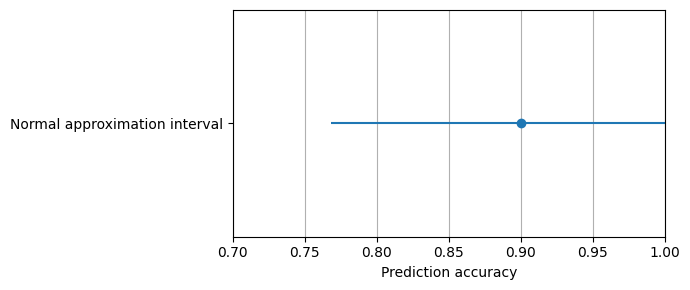

In [90]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 3))

ax.errorbar(acc_test, 0, xerr=ci_length, fmt="o")

ax.set_xlim([0.7, 1.0])

ax.set_yticks(np.arange(1))
ax.set_yticklabels(["Normal approximation interval"])
ax.set_xlabel("Prediction accuracy")

plt.tight_layout()
plt.grid(axis="x")
plt.show()

In [91]:
results = {
    "Method 1: Normal approximation": {
        "Test accuracy": acc_test,
        "Lower 95% CI": ci_lower,
        "Upper 95% CI": ci_upper,
    }
}

#### Metodo 2: Bootstrapping Training Sets – Setup Step

In [92]:
import numpy as np

rng = np.random.RandomState(seed=12345)
idx = np.arange(y_train.shape[0])

bootstrap_train_accuracies = []
bootstrap_rounds = 200
y_ = y_train.values

for i in range(bootstrap_rounds):

    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    valid_idx = np.setdiff1d(idx, train_idx, assume_unique=False)

    boot_train_X, boot_train_y = X_scaled[train_idx], y_[train_idx]
    boot_valid_X, boot_valid_y = X_scaled[valid_idx], y_[valid_idx]

    lr.fit(boot_train_X, boot_train_y)
    acc = lr.score(boot_valid_X, boot_valid_y)
    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)

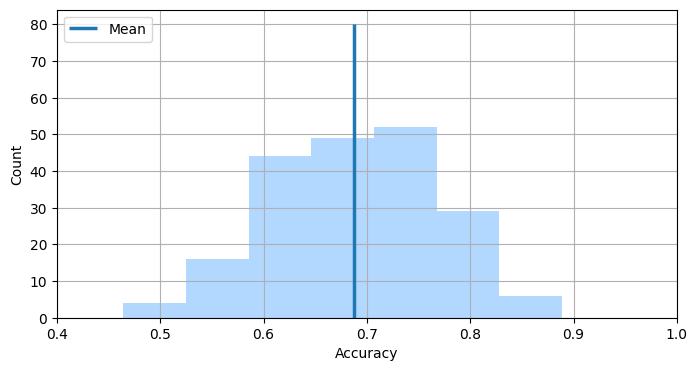

In [93]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.vlines(bootstrap_train_mean, [0], 80, lw=2.5, linestyle="-", label="Mean")

ax.hist(
    bootstrap_train_accuracies, bins=7, color="#0080ff", edgecolor="none", alpha=0.3
)

plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.xlim([0.4, 1])

plt.legend(loc="upper left")
plt.grid()
plt.show()

In [94]:
confidence = 0.95  # Change to your desired confidence level
t_value = scipy.stats.t.ppf((1 + confidence) / 2.0, df=bootstrap_rounds - 1)
print(t_value)

1.971956544249395


In [95]:
se = 0.0
for acc in bootstrap_train_accuracies:
    se += (acc - bootstrap_train_mean) ** 2
se = np.sqrt((1.0 / (bootstrap_rounds - 1)) * se)

ci_length = t_value * se

ci_lower = bootstrap_train_mean - ci_length
ci_upper = bootstrap_train_mean + ci_length

print(ci_lower, ci_upper)

0.5289075234716702 0.8463176565070674


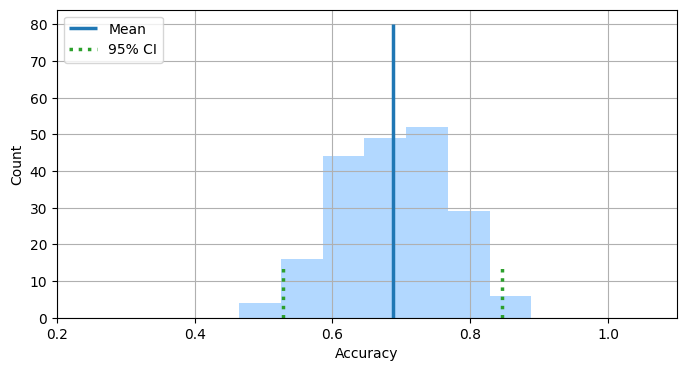

In [96]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(bootstrap_train_mean, [0], 80, lw=2.5, linestyle="-", label="Mean")

ax.vlines(ci_lower, [0], 15, lw=2.5, linestyle="dotted", label="95% CI", color="C2")
ax.vlines(ci_upper, [0], 15, lw=2.5, linestyle="dotted", color="C2")

ax.hist(
    bootstrap_train_accuracies, bins=7, color="#0080ff", edgecolor="none", alpha=0.3
)

plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.xlim([0.2, 1.1])

plt.legend(loc="upper left")

plt.grid()
plt.show()

In [97]:
results["Method 2.1: Bootstrap, 1-sample CI"] = {
    "Test accuracy": bootstrap_train_mean,
    "Lower 95% CI": ci_lower,
    "Upper 95% CI": ci_upper,
}

#### Method 2.2: Bootstrap Confidence Intervals Using the Percentile Method

In [98]:
ci_lower = np.percentile(bootstrap_train_accuracies, 2.5)
ci_upper = np.percentile(bootstrap_train_accuracies, 97.5)

print(ci_lower, ci_upper)

0.5383928571428571 0.84009375


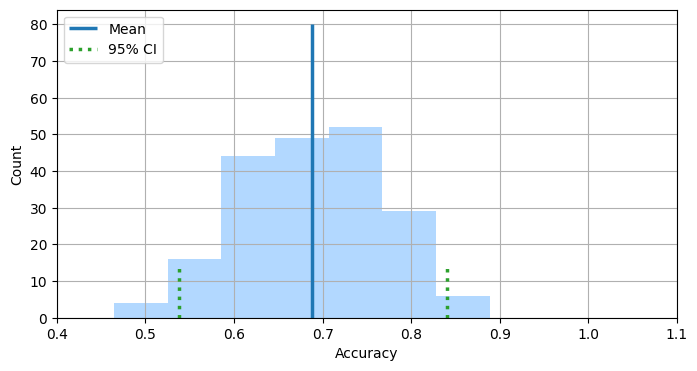

In [99]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(bootstrap_train_mean, [0], 80, lw=2.5, linestyle="-", label="Mean")

ax.vlines(ci_lower, [0], 15, lw=2.5, linestyle="dotted", label="95% CI", color="C2")
ax.vlines(ci_upper, [0], 15, lw=2.5, linestyle="dotted", color="C2")

ax.hist(
    bootstrap_train_accuracies, bins=7, color="#0080ff", edgecolor="none", alpha=0.3
)
plt.legend(loc="upper left")

plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.xlim([0.4, 1.1])

plt.grid()
plt.show()

In [100]:
valor8 = lr.predict(X_test_scaled).tolist()
valor7 = y_test.label.values.tolist()

In [101]:
results["Method 2.2: Bootstrap, percentile"] = {
    "Test accuracy": bootstrap_train_mean,
    "Lower 95% CI": ci_lower,
    "Upper 95% CI": ci_upper,
}

#### Method 2.3: Reweighting the Boostrap Samples via the .632 Bootstrap

In [102]:
rng = np.random.RandomState(seed=12345)
y_ = y_train.values
idx = np.arange(y_.shape[0])

bootstrap_train_accuracies = []
bootstrap_rounds = 200
weight = 0.632


for i in range(bootstrap_rounds):

    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    valid_idx = np.setdiff1d(idx, train_idx, assume_unique=False)

    boot_train_X, boot_train_y = X_scaled[train_idx], y_[train_idx]
    boot_valid_X, boot_valid_y = X_scaled[valid_idx], y_[valid_idx]

    lr.fit(boot_train_X, boot_train_y)
    valid_acc = lr.score(boot_valid_X, boot_valid_y)
    # predict training accuracy on the whole training set
    # as ib the original .632 boostrap paper
    # in Eq (6.12) in
    #    "Estimating the Error Rate of a Prediction Rule: Improvement
    #     on Cross-Validation"
    #     by B. Efron, 1983, https://doi.org/10.2307/2288636
    train_acc = lr.score(X_train, y_train)

    acc = weight * train_acc + (1.0 - weight) * valid_acc

    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)
bootstrap_train_mean

0.5829703804845088

In [103]:
ci_lower = np.percentile(bootstrap_train_accuracies, 2.5)
ci_upper = np.percentile(bootstrap_train_accuracies, 97.5)

print(ci_lower, ci_upper)

0.5153038461538462 0.6551552213868004


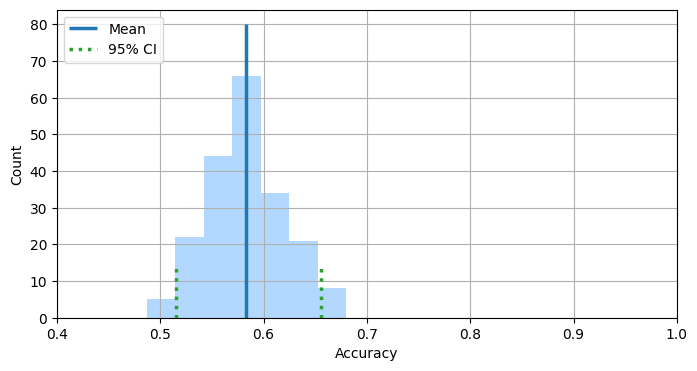

In [104]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(bootstrap_train_mean, [0], 80, lw=2.5, linestyle="-", label="Mean")

ax.vlines(ci_lower, [0], 15, lw=2.5, linestyle="dotted", label="95% CI", color="C2")
ax.vlines(ci_upper, [0], 15, lw=2.5, linestyle="dotted", color="C2")

ax.hist(
    bootstrap_train_accuracies, bins=7, color="#0080ff", edgecolor="none", alpha=0.3
)
plt.legend(loc="upper left")

plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.xlim([0.4, 1])

plt.grid()
plt.show()

In [105]:
results["Method 2.3: Bootstrap, .632"] = {
    "Test accuracy": bootstrap_train_mean,
    "Lower 95% CI": ci_lower,
    "Upper 95% CI": ci_upper,
}

#### Method 2.4: Taking the Reweighting One Step Further: The .632+ Bootstrap

In [106]:
X.head()

,ccbd_diameter,sl2l_mean_length,sl2l_diameter,ccbd_mean_length,sl2l_volume,tral_volume
0,27.36,77.97,25.07,111.24,38503.10,19479.70
1,25.31,71.58,21.35,115.11,25625.70,14019.30
2,26.07,60.09,15.17,109.94,10857.20,17719.00
3,30.96,74.39,21.80,110.00,27759.50,15856.40
4,24.65,76.13,25.37,131.73,38485.50,22291.20


In [107]:
X

,ccbd_diameter,sl2l_mean_length,sl2l_diameter,ccbd_mean_length,sl2l_volume,tral_volume
0,27.36,77.97,25.07,111.24,38503.10,19479.70
1,25.31,71.58,21.35,115.11,25625.70,14019.30
2,26.07,60.09,15.17,109.94,10857.20,17719.00
3,30.96,74.39,21.80,110.00,27759.50,15856.40
4,24.65,76.13,25.37,131.73,38485.50,22291.20
...,...,...,...,...,...,...
91,31.12,68.88,25.60,121.84,35449.80,15791.80
92,28.11,75.91,23.55,121.55,33050.50,7114.43
93,29.82,69.88,22.79,123.91,28517.50,18160.70
94,31.13,72.83,23.58,126.01,31796.10,19594.30


In [108]:
from itertools import product

from sklearn.metrics import accuracy_score


def no_information_rate(targets, predictions, loss_fn):
    combinations = np.array(list(product(targets, predictions)))
    return loss_fn(combinations[:, 0], combinations[:, 1])


rng = np.random.RandomState(seed=12345)
idx = np.arange(y_train.shape[0])
y_ = y_train.values

bootstrap_train_accuracies = []
bootstrap_rounds = 200
weight = 0.632


for i in range(bootstrap_rounds):

    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    valid_idx = np.setdiff1d(idx, train_idx, assume_unique=False)

    boot_train_X, boot_train_y = X_scaled[train_idx], y_[train_idx]
    boot_valid_X, boot_valid_y = X_scaled[valid_idx], y_[valid_idx]

    lr.fit(boot_train_X, boot_train_y)
    train_acc = lr.score(X_scaled, y_)
    valid_acc = lr.score(boot_valid_X, boot_valid_y)

    gamma = no_information_rate(y, lr.predict(X.loc[:, X.columns != 'const']), accuracy_score)
    R = (valid_acc - train_acc) / (gamma - train_acc)

    weight = 0.632 / (1 - 0.368 * R)

    acc = weight * train_acc + (1.0 - weight) * valid_acc

    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)
bootstrap_train_mean

0.7179649507975897

In [109]:
ci_lower = np.percentile(bootstrap_train_accuracies, 2.5)
ci_upper = np.percentile(bootstrap_train_accuracies, 97.5)

print(ci_lower, ci_upper)

0.6493357604186722 0.7857564583673854


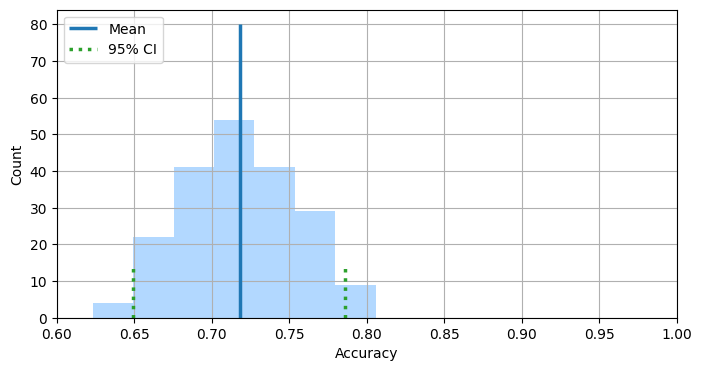

In [110]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(bootstrap_train_mean, [0], 80, lw=2.5, linestyle="-", label="Mean")

ax.vlines(ci_lower, [0], 15, lw=2.5, linestyle="dotted", label="95% CI", color="C2")
ax.vlines(ci_upper, [0], 15, lw=2.5, linestyle="dotted", color="C2")

ax.hist(
    bootstrap_train_accuracies, bins=7, color="#0080ff", edgecolor="none", alpha=0.3
)

plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.xlim([0.6, 1.0])

plt.legend(loc="upper left")

plt.grid()
plt.show()

In [111]:
results["Method 2.4: Bootstrap, .632+"] = {
    "Test accuracy": bootstrap_train_mean,
    "Lower 95% CI": ci_lower,
    "Upper 95% CI": ci_upper,
}

#### Method 3: Bootstrapping the Test Set Predictions

In [129]:
lr.fit(X_scaled, y_train)
y_ = y_test.values
predictions_test = lr.predict(X_test_scaled)
acc_test = np.mean(predictions_test == y_)

rng = np.random.RandomState(seed=12345)
idx = np.arange(y_test.shape[0])

test_accuracies = []

for i in range(200):
    pred_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    
    acc_test_boot = np.mean(predictions_test[pred_idx] == y_[pred_idx])
    test_accuracies.append(acc_test_boot)

bootstrap_train_mean = np.mean(test_accuracies)
bootstrap_train_mean

0.540225

In [130]:
ci_lower = np.percentile(test_accuracies, 2.5)
ci_upper = np.percentile(test_accuracies, 97.5)

print(ci_lower, ci_upper)

0.49 0.68


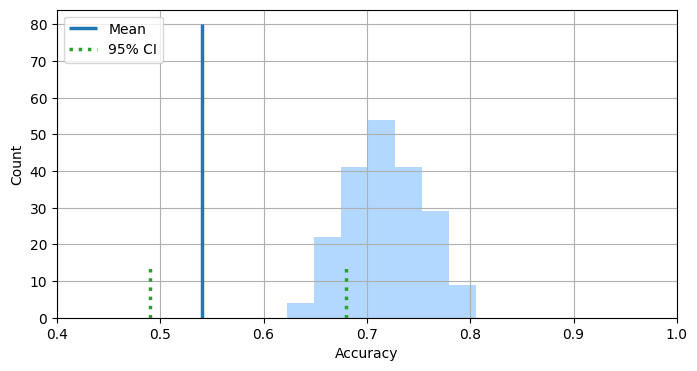

In [132]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(bootstrap_train_mean, [0], 80, lw=2.5, linestyle="-", label="Mean")

ax.vlines(ci_lower, [0], 15, lw=2.5, linestyle="dotted", label="95% CI", color="C2")
ax.vlines(ci_upper, [0], 15, lw=2.5, linestyle="dotted", color="C2")

ax.hist(
    bootstrap_train_accuracies, bins=7, color="#0080ff", edgecolor="none", alpha=0.3
)

plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.xlim([0.4, 1.0])

plt.legend(loc="upper left")

plt.grid()
plt.show()

In [135]:
results["Method 3: Bootstrap test set"] = {
    "Test accuracy": bootstrap_train_mean,
    "Lower 95% CI": ci_lower,
    "Upper 95% CI": ci_upper,
}

#### Comparación de los resultados de los modelos

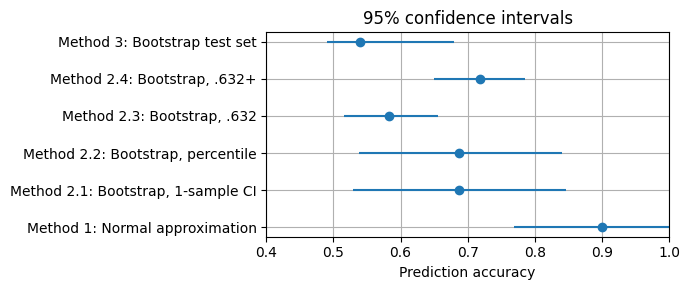

In [139]:
labels = list(results.keys())

means = np.array([results[k]["Test accuracy"] for k in labels])
lower_error = np.array([results[k]["Lower 95% CI"] for k in labels])
upper_error = np.array([results[k]["Upper 95% CI"] for k in labels])

asymmetric_error = [means - lower_error, upper_error - means]


fig, ax = plt.subplots(figsize=(7, 3))
ax.errorbar(means, np.arange(len(means)), xerr=asymmetric_error, fmt="o")
ax.set_xlim([0.4, 1.0])
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(labels)
ax.set_xlabel("Prediction accuracy")
ax.set_title("95% confidence intervals")

plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valor7, valor8) 
metricas = balanced_accuracy(cm)
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

Matriz de confusion del modelo es:
[[ 7  1]
 [ 2 10]]
Sensibilidad del modelo es de: 0.9091
Especificidad del modelo es de: 0.7778
BA del modelo es de: 0.8434


In [ ]:
ci_lower = np.percentile(bootstrap_train_accuracies, 2.5)
ci_upper = np.percentile(bootstrap_train_accuracies, 97.5)

print(ci_lower, ci_upper)

0.4230769230769231 0.7777777777777778


In [ ]:
X = sm.add_constant(X) 
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  label   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     9.475
Date:                Sat, 22 Jul 2023   Prob (F-statistic):           4.90e-08
Time:                        20:26:29   Log-Likelihood:                -45.884
No. Observations:                  96   AIC:                             105.8
Df Residuals:                      89   BIC:                             123.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.5957      3.019  

In [ ]:
from mlxtend.data import iris_data


X1, y1 = iris_data()

In [ ]:
X1

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [ ]:
X1.shape, y1.shape

((150, 4), (150,))

In [ ]:
X_train.shape, y_train.shape

((76, 6), (76, 1))